# Prediction with Machine Learning HW2, Mukhamejan Assan

Business: Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. 

Build a price prediction model similarly to how we did in our case study for London. 

Discuss your modeling decisions and compare your results to those of the case study. 


## EDA

In [675]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [676]:
df = pd.read_csv('listings.csv')
df.shape 

(11056, 75)

In [677]:
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_')

### The variables, their description, and type

In [678]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11056 non-null  int64  
 1   listing_url                                   11056 non-null  object 
 2   scrape_id                                     11056 non-null  int64  
 3   last_scraped                                  11056 non-null  object 
 4   source                                        11056 non-null  object 
 5   name                                          11054 non-null  object 
 6   description                                   11018 non-null  object 
 7   neighborhood_overview                         7087 non-null   object 
 8   picture_url                                   11056 non-null  object 
 9   host_id                                       11056 non-null 

Some of the 73 variables may not be useful. 

1. Variables that cannot be changed:

    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name'

2. Variables that are not relevant because the listings have not yet been introduced into the market:

    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'

In [679]:
df.shape

(11056, 75)

In [680]:
df.drop(
    ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name','host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'],
    inplace=True,
    axis=1
)

# Feature Engineering

## Encoding property type

We are only interested in apartments.
1. Check if property types are all indicated 
2. keep only apartments

In [681]:
print(df["property_type"].isnull().sum(), "property types are missing.")

0 property types are missing.


Property types do not seem to be well-defined. I will find the apartment listings by finding the `partment` in descriptions and then select the property types that say either "Entire" or "Home" but not "room".

In [682]:
print(df[df['description'].str.contains('partment',na=False)].property_type.value_counts())
df = df[df['description'].str.contains('partment',na=False)]

Entire rental unit                    4843
Entire condo                          1419
Private room in rental unit            192
Entire serviced apartment              175
Entire loft                             93
Entire home                             89
Room in aparthotel                      83
Private room in condo                   63
Room in serviced apartment              38
Private room in serviced apartment      26
Room in boutique hotel                  12
Entire vacation home                    11
Private room in guest suite             11
Shared room in rental unit              10
Entire guest suite                       9
Room in hotel                            8
Entire townhouse                         5
Tiny home                                4
Private room in bed and breakfast        3
Private room in vacation home            2
Entire villa                             2
Entire place                             2
Private room in hostel                   2
Private roo

In [683]:
# keeping only the apartments
df = df[df.property_type.apply(lambda x: ("Entire" in x or 'ome' in x) and 'room' not in x).to_list()]
# What is left in the end? 
df.property_type.value_counts()
# Still way too many categories. Focus on the 4 biggest, and give a sensible name to each. 
df = df[df['property_type'].apply(lambda x: x in ("Entire rental unit Entire condo Entire serviced apartment Entire loft"))]

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text
d = { "Entire rental unit": "Apartment", "Entire condo": "Condo", "Entire serviced apartment": "Serviced apartment","Entire loft" : "Loft"}

df['property_type'] = replace_all(df["property_type"], d)


In [684]:
df['property_type'].value_counts()

Apartment             4843
Condo                 1419
Serviced apartment     175
Loft                    93
Name: property_type, dtype: int64

Now, we need to limit our data to apartments which accomodate 2-6 people. 

In [685]:
df = df[df['accommodates'].between(2,6)]

In [686]:
# Since we are focusing only on apartments that can be entirely rented out, we will drop the room type column
print("Only", len(df['room_type'].unique()), "unique value for room_type")
df.drop('room_type', axis=1, inplace=True)

Only 1 unique value for room_type


In [687]:
property_dummies = pd.get_dummies(df["property_type"], prefix="prop", drop_first=True)
property_dummies.columns = property_dummies.columns.str.replace('[^a-zA-Z0-9_]', '_')
df = pd.concat([df, property_dummies], axis=1)
property_dummies
# Apartment is the base

,prop_Condo,prop_Loft,prop_Serviced_apartment
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,1,0
...,...,...,...
11029,0,0,0
11030,0,0,0
11031,0,0,0
11051,0,0,0


## Missing values

There are 17229 missing values in total


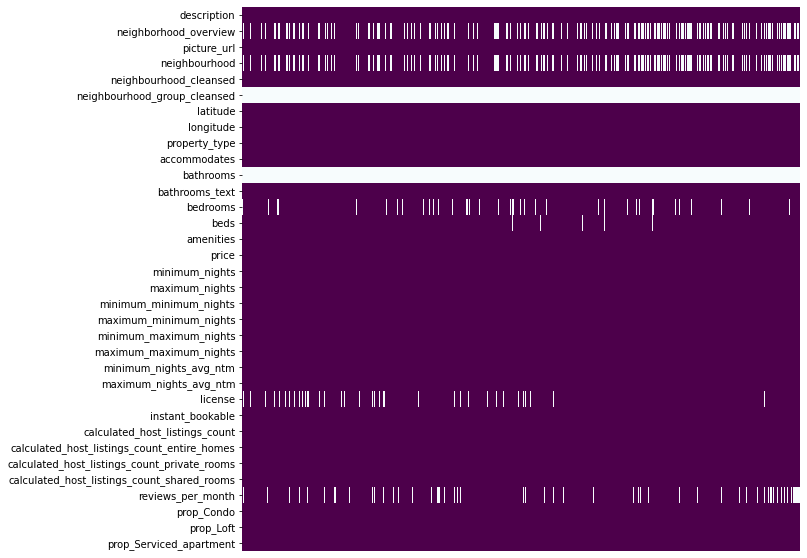

In [688]:
# Check for missing values frequency
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.isnull().T, xticklabels=False, cbar=False, cmap='BuPu_r', ax=ax)
print('There are', df.isna().sum().sum(), 'missing values in total')

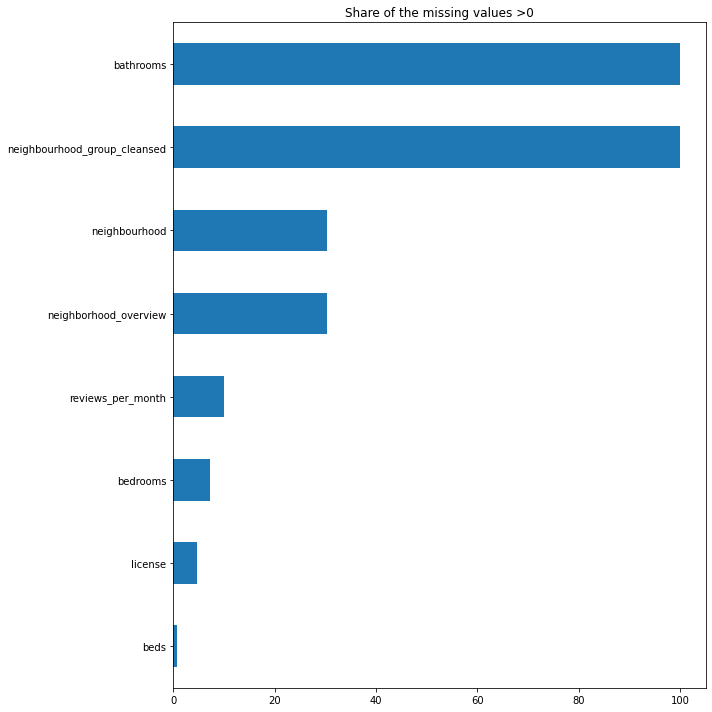

In [689]:
# focus on features with missing values
na_share = df.isnull().mean()*100
fig, ax = plt.subplots(figsize=(10,10))    
na_share[na_share>0].sort_values(ascending=True).plot.barh(title = 'Share of the missing values >0')
plt.tight_layout()

In [690]:
df.dropna(subset=['beds'], inplace=True)

In [691]:
na_share[na_share>0].sort_values(ascending=False)

neighbourhood_group_cleansed    100.000000
bathrooms                       100.000000
neighborhood_overview            30.378289
neighbourhood                    30.378289
reviews_per_month                10.065789
bedrooms                          7.138158
license                           4.753289
beds                              0.657895
dtype: float64

In [692]:
df['price'] = df['price'].apply(lambda x: int(float(x.replace('$', '').replace(',',''))))
df['log_price'] = np.log(df['price'])

## Encoding the neighborhoods

Since the data on neighborhoods is not clean, I am mapping the coordiantes of the listings to the electoral districts of Athens. My assumptions is that this division groups similar households/apartments. Data source: https://tipsforgis.wordpress.com/2018/09/26/leaflet-map-1/

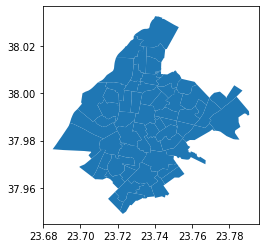

In [693]:
import geopandas as gpd

# Read the JSON file into a GeoDataFrame
data = gpd.read_file("daeklogikadiamerismata.json")

# Plot the GeoDataFrame
data.plot()

# Show the plot
plt.show()


In [694]:
from shapely.geometry import Point

# define a function to get the "fid" value for a given point
def get_fid(row):
    point = Point(row['longitude'], row['latitude'])
    for j, polygon in data.iterrows():
        if polygon["geometry"].contains(point):
            fid = polygon["fid"]
            return fid
    return None

# apply the function to create a new column in df with the "fid" values
df['fid'] = df.apply(get_fid, axis=1)

In [695]:
df['fid']

1        26.0
2        26.0
3        26.0
4        26.0
5        49.0
         ... 
11029    45.0
11030    59.0
11031    61.0
11051    45.0
11054    56.0
Name: fid, Length: 6040, dtype: float64

In [696]:
df[['price', 'fid', 'log_price']]

,price,fid,log_price
1,75,26.0,4.317488
2,60,26.0,4.094345
3,42,26.0,3.737670
4,75,26.0,4.317488
5,68,49.0,4.219508
...,...,...,...
11029,100,45.0,4.605170
11030,48,59.0,3.871201
11031,41,61.0,3.713572
11051,56,45.0,4.025352


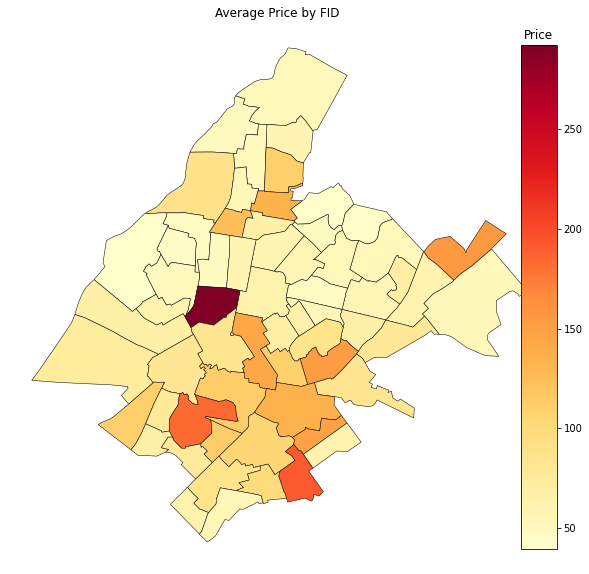

In [697]:
# Group the listings by fid and calculate the mean price
price_by_fid = df.groupby('fid')['price'].mean()

# Join the average prices back to the GeoDataFrame
data_with_price = data.join(price_by_fid, on='fid')

# Plot the average price by fid on the map
fig, ax = plt.subplots(figsize=(10,10))
data_with_price.plot(column='price', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='black')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=data_with_price['price'].min(), vmax=data_with_price['price'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04, ax=ax, cax=plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7]))
cbar.ax.set_title('Price')

ax.axis('off')
ax.set_title('Average Price by FID')
plt.show()

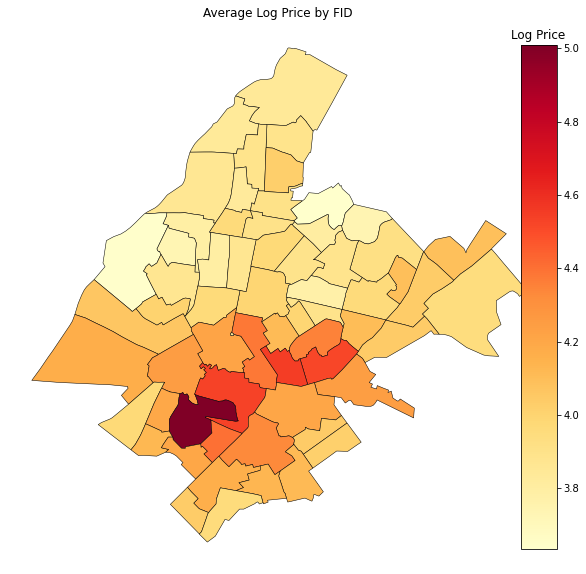

In [698]:
# Group the listings by fid and calculate the mean log price
log_price_by_fid = df.groupby('fid')['log_price'].mean()

# Join the average log prices back to the GeoDataFrame
data_with_log_price = data.join(log_price_by_fid, on='fid')

# Plot the average log price by fid on the map
fig, ax = plt.subplots(figsize=(10,10))
data_with_log_price.plot(column='log_price', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='black')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=data_with_log_price['log_price'].min(), vmax=data_with_log_price['log_price'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04, ax=ax, cax=plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7]))
cbar.ax.set_title('Log Price')

ax.axis('off')
ax.set_title('Average Log Price by FID')
plt.show()

Average log_price makes much more sense and looks like the location is affecting the price a lot. 

In [699]:
print("There are only", df['fid'].isna().sum(), "listings without an assigned district.")

There are only 4 listings without an assigned district.


In [700]:
df.dropna(subset=['fid'], inplace=True)

df['fid'] = df['fid'].astype(int)

# Create dummy variables for the fid variable
fid_dummies = pd.get_dummies(df["fid"], prefix="neighborhood")
fid_dummies.columns = fid_dummies.columns.str.replace('[^a-zA-Z0-9_]', '_')

# Concatenate the original DataFrame with the new dummy variables
df = pd.concat([df, fid_dummies], axis=1)

# Drop the original fid variable
df.drop("fid", axis=1, inplace=True)

## Recovering the number of bathrooms

In [701]:
# Check how many instance have bathroom info missing
print(df['bathrooms_text'].isnull().sum(), "instances have missing information on bathrooms count")

# Define a dictionary that maps each bathroom value to its corresponding numeric value
bathroom_mapping = {'1 bath': 1, '1.5 baths': 1.5, '2 baths': 2, '2.5 baths': 2.5, '0 baths': 0, '3 baths': 3, '3.5 baths': 3.5, 'Half-bath': 0.5, '4 baths': 4}

# Replace the values in the 'bathrooms_text' column with their corresponding numeric values
df['bathrooms'] = df['bathrooms_text'].replace(bathroom_mapping)

0 instances have missing information on bathrooms count


## Recovering the number of bedrooms

In [702]:
from sklearn.linear_model import LinearRegression

# Subset the dataframe to only the relevant columns
df_subset = df[['accommodates', 'bedrooms', 'beds']]

# Split the data into complete and missing subsets
complete_data = df_subset.dropna()
missing_data = df_subset[df_subset.isna().any(axis=1)]

# Fit a linear regression model to the complete data
lr_model = LinearRegression()
lr_model.fit(complete_data[['accommodates', 'beds']], complete_data['bedrooms'])

# Predict the missing values using the model
missing_data['bedrooms'] = lr_model.predict(missing_data[['accommodates', 'beds']])

# Combine the complete and imputed data
imputed_data = pd.concat([complete_data, missing_data], axis=0)

# Replace the original 'bedrooms' column with the imputed values
df['bedrooms'] = imputed_data['bedrooms']

# round to integer values
df['bedrooms'] = df['bedrooms'].astype(int)


## Amenities

In [703]:
# Count the amenities
amenities_count = df['amenities'].str.strip('[]').str.replace('"', '').str.split(',').explode().str.strip().value_counts().reset_index().rename(columns={'index':'amenity', 'amenities':'count'})

# Get the top 30
top_amenities_30 = amenities_count.nlargest(30, 'count')['amenity'].tolist()

# Create a new DataFrame to hold the binary variables
amenities_df = pd.DataFrame(index=df.index)


# Encode each amenity as a binary variable in the amenities DataFrame
for amenity in top_amenities_30:
    amenities_df[f"am_{amenity}"] = df["amenities"].str.contains(amenity).astype(int)
amenities_df.columns = amenities_df.columns.str.replace('[^a-zA-Z0-9_]', '_')
# Concatenate the original DataFrame with the new amenities DataFrame
df = pd.concat([df, amenities_df], axis=1)

In [704]:
corr_matrix = df.corr()
log_price_corr = corr_matrix['log_price'].abs().sort_values(ascending=False)
top_predictors = log_price_corr.nlargest(21)[1:].index.tolist()
top_predictors

['price',
 'bathrooms',
 'accommodates',
 'bedrooms',
 'beds',
 'latitude',
 'neighborhood_49',
 'am_TV',
 'am_Free_street_parking',
 'am_Fire_extinguisher',
 'maximum_nights',
 'neighborhood_56',
 'neighborhood_47',
 'neighborhood_22',
 'am_Microwave',
 'calculated_host_listings_count',
 'prop_Serviced_apartment',
 'calculated_host_listings_count_private_rooms',
 'am_Coffee_maker',
 'calculated_host_listings_count_entire_homes']

## Booking admin

In [705]:
df["instant_bookable"] = df["instant_bookable"].replace({"t": 1, "f": 0})
df[['minimum_nights', 'maximum_nights', 'instant_bookable']].isna().sum()

minimum_nights      0
maximum_nights      0
instant_bookable    0
dtype: int64

## Quantifying listing description

Well-written listing descriptions might catch an eye of the customer, and the poorly-written listing might decrease the confidence of the user about the credibility of the listing or the easiness of contact with the host. To test this motivation I quantify the sentiment score and the readability of listings.

In [706]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression

# Initialize the NLTK sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate the sentiment scores for each description
sentiment_scores = []
for description in df['description']:
    score = sia.polarity_scores(description)['compound']
    sentiment_scores.append(score)
df['sentiment_score'] = sentiment_scores

import textstat

# Calculate readability scores for each description
df['gunning_fog'] = df['description'].apply(lambda x: textstat.gunning_fog(str(x)))

# Feature selection

In [707]:
# Basic property descriptors
property_type = property_dummies.columns.to_list()
prop = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds'
] + property_type

# Location dummies
location = fid_dummies.columns.to_list()

# Amenitites dummies
amenities = amenities_df.columns.to_list()

# Description scores
description = [
    'sentiment_score', 'gunning_fog'
]

# Booking specificaiton
booking = [
    'minimum_nights', 'maximum_nights', "instant_bookable"
]

In [708]:
model1 = prop
model2 = prop + amenities
model3 = prop + amenities + description
model4 = prop + amenities + description + booking
model5 = prop + amenities + description + booking + location

I am explanding the list of predictors to compare the model performances. I put similar features in the same groups, and put another group to a later model by the order of importance. The importance here was judged from personal perspective. Below, I use Random Forest Regressor to give me a list of "important" features, and keeping those that have the importance score higher than 1%. This consitutes the last model.

In [709]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Combine all features into a list
features = model5

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df['log_price'], test_size=0.2, random_state=42)

# Train a random forest regressor on the training set
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a table of feature names and importances
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Add a column for the cumulative importance
feature_importances['Cumulative Importance'] = feature_importances['Importance'].cumsum()

# Convert importance values to percentage
feature_importances['Importance'] = (feature_importances['Importance'] * 100).round(2)

# Convert cumulative importance values to percentage
feature_importances['Cumulative Importance'] = (feature_importances['Cumulative Importance'] / feature_importances['Importance'].sum() * 10000).round(2)

# Print the table of feature names and importances
feature_importances[feature_importances['Importance']>0.95]


,Feature,Importance,Cumulative Importance
38,gunning_fog,12.01,12.00
1,bathrooms,10.50,22.50
37,sentiment_score,9.89,32.38
2,bedrooms,5.54,37.93
0,accommodates,4.98,42.90
89,neighborhood_49,4.06,46.96
40,maximum_nights,3.94,50.89
39,minimum_nights,3.48,54.37
3,beds,1.60,55.97
96,neighborhood_56,1.40,57.37


In [710]:
feature_importances['Importance']=feature_importances['Importance'].round(0)

In [711]:
model6 = feature_importances[feature_importances['Importance']>=1]['Feature'].to_list()

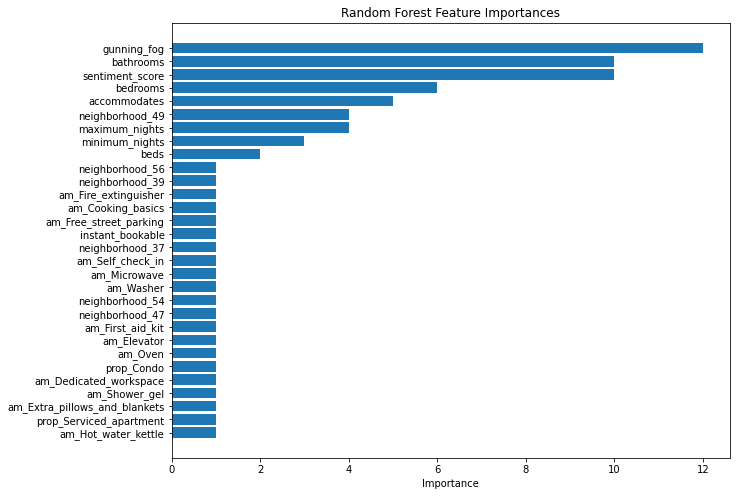

In [712]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Create a bar chart of feature importances
plt.barh(feature_importances['Feature'][:30], feature_importances['Importance'][:30])

# Add x-axis label and title
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')

# Invert the y-axis so that the most important feature is at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()


In [713]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error


features_list = [model1, model2, model3, model4, model5, model6]

# Split the data into train, test, and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=16042023)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=16042023)

# Define a function to perform OLS regression and return RMSE
def run_regression(X, y):
    model = LinearRegression()
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return np.mean(rmse_scores)

# Create a dictionary to store the results
results = {}

# Loop through the four sets of features and perform OLS regression on each
for i, features in enumerate(features_list):
    X_train = train_df[features]
    y_train = train_df['log_price']
    X_val = val_df[features]
    y_val = val_df['log_price']
    rmse = run_regression(X_train, y_train)
    results['Model {}'.format(i+1)] = [rmse.round(2)]
    
    # Compute RMSE on validation set
    y_pred = LinearRegression().fit(X_train, y_train).predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred)).round(2)
    results['Model {}'.format(i+1)].append(rmse_val)
    
    # Compute RMSE on test set
    X_test = test_df[features]
    y_test = test_df['log_price']
    y_pred = LinearRegression().fit(X_train, y_train).predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    results['Model {}'.format(i+1)].append(rmse_test)

# Print the table of results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE (train)', 'RMSE (validation)', 'RMSE (test)'])
print(results_df)


         RMSE (train)  RMSE (validation)  RMSE (test)
Model 1          0.54               0.59         0.55
Model 2          0.53               0.57         0.53
Model 3          0.53               0.56         0.52
Model 4          0.52               0.56         0.52
Model 5          0.50               0.54         0.50
Model 6          0.50               0.54         0.50


Best performing (in terms of RMSE) model seems to be Model 5 and 6. 

In [714]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

features = prop + location + amenities + description + booking

# define dependent variable
y = df['log_price']

# divide into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.2, random_state=16042023)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=16042023)

# define models
models = [model1, model2, model3, model4, model5, model6]

# run cross-validation on each model
k = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for model in models:
    formula = 'log_price ~ ' + ' + '.join(model)
    cv_fold_results = {'model': model, 'rmse_train': [], 'rmse_val': []}
    for train_idx, val_idx in k.split(X_train):
        train_data = X_train.iloc[train_idx]
        train_y = y_train.iloc[train_idx]
        val_data = X_train.iloc[val_idx]
        val_y = y_train.iloc[val_idx]
        train_data['log_price'] = train_y
        val_data['log_price'] = val_y
        model = ols(formula=formula, data=train_data).fit()
        train_preds = model.predict(train_data)
        val_preds = model.predict(val_data)
        rmse_train = rmse(train_y, train_preds)
        rmse_val = rmse(val_y, val_preds)
        cv_fold_results['rmse_train'].append(rmse_train)
        cv_fold_results['rmse_val'].append(rmse_val)
    cv_results.append(cv_fold_results)

# compile results into table
results_table = pd.DataFrame()
for i, model_results in enumerate(cv_results):
    model_name = 'Model ' + str(i+1)
    results_table[model_name] = model_results['rmse_val']
results_table.index = ['Fold ' + str(i+1) for i in range(5)]
results_table.loc['Mean'] = results_table.mean()
results_table.loc['Std Dev'] = results_table.std()
results_table = results_table.round(2)

# print results
print(results_table)


         Model 1  Model 2  Model 3  Model 4  Model 5  Model 6
Fold 1      0.54     0.52     0.52     0.52     0.50     0.49
Fold 2      0.57     0.56     0.56     0.55     0.53     0.53
Fold 3      0.56     0.55     0.55     0.55     0.52     0.53
Fold 4      0.53     0.52     0.52     0.52     0.49     0.49
Fold 5      0.56     0.54     0.54     0.54     0.51     0.51
Mean        0.55     0.54     0.54     0.53     0.51     0.51
Std Dev     0.02     0.02     0.01     0.01     0.01     0.02


Same result here, just seeing the cross-validation.

       Model 1  Model 2  Model 3  Model 4  Model 5  Model 6
Train     0.55     0.53     0.53     0.53     0.49     0.50
Test      0.55     0.53     0.52     0.52     0.50     0.50
BIC    6408.77  6388.40  6371.70  6364.66  6351.39  6061.26


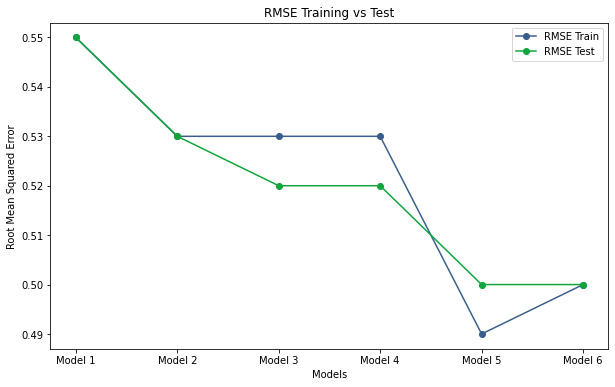

In [715]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse,bic
import matplotlib.pyplot as plt

features = prop + location + amenities + description + booking

# define dependent variable
y = df['log_price']

# divide into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.2, random_state=16042023)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=16042023)

# define models
models = [model1, model2, model3, model4, model5, model6]

# run cross-validation on each model
k = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for model in models:
    formula = 'log_price ~ ' + ' + '.join(model)
    cv_fold_results = {'model': model, 'rmse_train': [], 'rmse_test': [], 'BIC': []}
    train_data = X_train.copy()
    train_data['log_price'] = y_train
    test_data = X_test.copy()
    test_data['log_price'] = y_test
    model = ols(formula=formula, data=train_data).fit(cov_type='HC1')
    train_preds = model.predict(train_data)
    test_preds = model.predict(test_data)
    rmse_train = rmse(y_train, train_preds)
    rmse_test = rmse(y_test, test_preds)
    bic = model.bic
    cv_fold_results['rmse_train'].append(rmse_train)
    cv_fold_results['rmse_test'].append(rmse_test)
    cv_fold_results['BIC'].append(bic)
    cv_results.append(cv_fold_results)

# compile results into table
results_table = pd.DataFrame()
for i, model_results in enumerate(cv_results):
    model_name = 'Model ' + str(i+1)
    results_table[model_name] = [model_results['rmse_train'][0].round(2), model_results['rmse_test'][0].round(2), model_results['BIC'][0].round(2)]
results_table.index = ['Train', 'Test', 'BIC']
results_table = results_table.round(2)

# print results
print(results_table)

# plot results
plt.figure(figsize=(10, 6))
plt.plot([1, 2, 3, 4, 5, 6], results_table.loc['Train'], 'o-', color="#3a5e8c", label='RMSE Train')
plt.plot([1, 2, 3, 4, 5, 6], results_table.loc['Test'], 'o-', color="#10a53d", label='RMSE Test')
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE Training vs Test')
plt.xticks([1, 2, 3, 4, 5, 6], ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'])
plt.legend()
plt.show()


The analysis above suggests that Model 6 is the best choice. It is almost as rich as Model 5, but is not suffering from over/under-fitting issues.

Surprisingly, as seen below, OLS seems to be the best model in terms of the RMSE and its consistency in training and testing sets.

In [716]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import RandomizedSearchCV

# define dependent variable
y = df['log_price']

# divide into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df[model6], y, test_size=0.2, random_state=16042023)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=16042023)

# define OLS model
ols_model = smf.ols(formula='log_price ~ ' + ' + '.join(model6), data=df)
ols_results = ols_model.fit()
ols_train_preds = ols_results.predict(X_train)
ols_test_preds = ols_results.predict(X_test)
ols_rmse_train = rmse(y_train, ols_train_preds)
ols_rmse_test = rmse(y_test, ols_test_preds)

# define LASSO model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_train_preds = lasso_model.predict(X_train)
lasso_test_preds = lasso_model.predict(X_test)
lasso_rmse_train = rmse(y_train, lasso_train_preds)
lasso_rmse_test = rmse(y_test, lasso_test_preds)

# define CART model
cart_model = DecisionTreeRegressor(random_state=42)

# find ccp_alphas and impurities
path = cart_model.cost_complexity_pruning_path(X_train, y_train.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# use RandomizedSearchCV to find the best ccp_alpha
cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X_train, y_train.ravel())

# train a new CART model with the best ccp_alpha
best_cart_model = DecisionTreeRegressor(
    ccp_alpha=cart_model_cv.best_params_["ccp_alpha"], 
    random_state=42
)
best_cart_model.fit(X_train, y_train)

# evaluate the new model on the training and test sets
cart_train_preds = best_cart_model.predict(X_train)
cart_test_preds = best_cart_model.predict(X_test)
cart_rmse_train = rmse(y_train, cart_train_preds)
cart_rmse_test = rmse(y_test, cart_test_preds)


# define random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)
rf_rmse_train = rmse(y_train, rf_train_preds)
rf_rmse_test = rmse(y_test, rf_test_preds)

# create table of results
results = {'Model': ['OLS', 'LASSO', 'CART', 'Random Forest'],
           'RMSE Train': [ols_rmse_train.round(4), lasso_rmse_train.round(4), cart_rmse_train.round(4), rf_rmse_train.round(4)],
           'RMSE Test': [ols_rmse_test.round(4), lasso_rmse_test.round(4), cart_rmse_test.round(4), rf_rmse_test.round(4)]}

results_df = pd.DataFrame.from_dict(results)
results_df


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .ccp_alpha=2.0281994244073034e-06;, score=-0.799 total time=   0.0s
[CV 2/5] END .ccp_alpha=2.0281994244073034e-06;, score=-0.760 total time=   0.1s
[CV 3/5] END .ccp_alpha=2.0281994244073034e-06;, score=-0.692 total time=   0.0s
[CV 4/5] END .ccp_alpha=2.0281994244073034e-06;, score=-0.775 total time=   0.0s
[CV 5/5] END .ccp_alpha=2.0281994244073034e-06;, score=-0.666 total time=   0.1s
[CV 1/5] END ..ccp_alpha=9.010634185436269e-06;, score=-0.796 total time=   0.1s
[CV 2/5] END ..ccp_alpha=9.010634185436269e-06;, score=-0.759 total time=   0.1s
[CV 3/5] END ..ccp_alpha=9.010634185436269e-06;, score=-0.693 total time=   0.1s
[CV 4/5] END ..ccp_alpha=9.010634185436269e-06;, score=-0.775 total time=   0.1s
[CV 5/5] END ..ccp_alpha=9.010634185436269e-06;, score=-0.666 total time=   0.1s
[CV 1/5] END ..ccp_alpha=6.990951922750941e-06;, score=-0.796 total time=   0.1s
[CV 2/5] END ..ccp_alpha=6.990951922750941e-06;,

,Model,RMSE Train,RMSE Test
0,OLS,0.5047,0.4945
1,LASSO,0.5754,0.5784
2,CART,0.1233,0.6965
3,Random Forest,0.1941,0.5135


# Discussion

Based on the analysis, I would the following outline the most imporant features of a listing to a potential client (the host).

The top drivers of the listing price in Athens are:
1. Service
    Amenitites like Wi-Fi, TV, iron, air conditioning increase the comfort of the stay and hence could be charged more for presence. Among all the other amenities, these seem to add the most to the value of the stay.
2. Client experience: 
    The description of the listing is a mute salesman. The more professional and nicer it is, the higher is the willingness to book this specific listing. Moreover, lowering the barriers to booking the stay increases the attractiveness of the listing. 
3. Location: Since Athens is rich in historical landmarks, there is no single "hot area". The listing could add a markup according to the graph below. 

In [718]:
import statsmodels.api as sm
# fit the OLS model with location dummies
model = sm.OLS(df["log_price"], df[model6]).fit()

# create a dataframe with the coefficients, standard errors, and p-values
coef_table = pd.DataFrame({'coef': model.params, 'std err': model.bse, 'p-value': model.pvalues})

# add asterisks to indicate significance levels
def add_asterisks(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

coef_table['sig'] = coef_table['p-value'].apply(add_asterisks)

# sort the table by coefficient value and round to two decimal places
coef_table = coef_table.sort_values(by='coef', ascending=False).round(2)

coef_table


,coef,std err,p-value,sig
am_Wifi,0.62,0.03,0.00,***
bathrooms,0.62,0.03,0.00,***
am_TV,0.60,0.03,0.00,***
sentiment_score,0.51,0.03,0.00,***
neighborhood_49,0.43,0.03,0.00,***
neighborhood_46,0.42,0.06,0.00,***
neighborhood_47,0.41,0.05,0.00,***
neighborhood_39,0.38,0.04,0.00,***
neighborhood_54,0.33,0.04,0.00,***
neighborhood_56,0.30,0.03,0.00,***


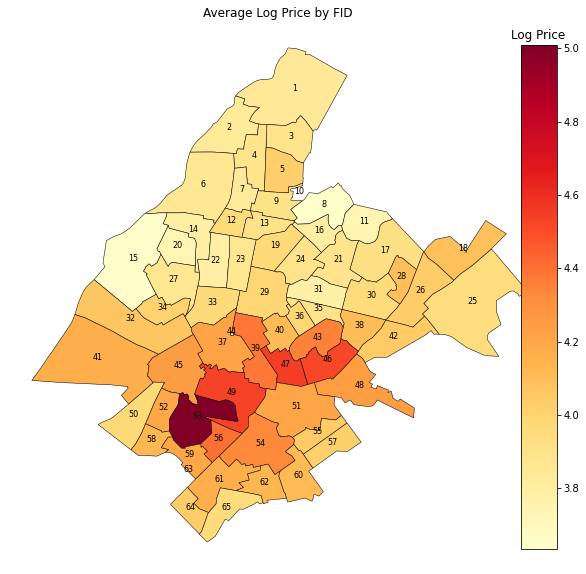

In [719]:
# Plot the average log price by fid on the map
fig, ax = plt.subplots(figsize=(10,10))
data_with_log_price.plot(column='log_price', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='black')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=data_with_log_price['log_price'].min(), vmax=data_with_log_price['log_price'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04, ax=ax, cax=plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7]))
cbar.ax.set_title('Log Price')

# Add FID labels
for _, row in data_with_log_price.iterrows():
    ax.annotate(text=row['fid'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)

ax.axis('off')
ax.set_title('Average Log Price by FID')
plt.show()
